# **Resolución de la ecuación del calor unidimensional aplicada a una barra de largo L y grosor infinitesimal**

## **Importación de librerías y preparación de entorno**

In [1]:
%env DDE_BACKEND=tensorflow.compat.v1
# %env DDE_BACKEND = tensorflow

env: DDE_BACKEND=tensorflow.compat.v1


In [2]:
import numpy as np
import deepxde as dde
from deepxde.backend import tf
from modulePINN import Geometry, IC_BC, loadData, PINN, Ploter, Makegrid

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


## **Definición de parámetros geométricos del problema**

In [4]:
params_barra = [0, 1, 0, 1] # (t_min, t_max, L_0, L)
barra = Geometry() # Creamos el objeto geométrico: barra
# Creamos el dominio espacio-temporal de la barra
geom_barra, timedomain_barra, geomtime_barra = barra.geometry_domain(params_barra)

In [5]:
icbc = IC_BC(geomtime_barra) # construimos el objeto de condicones iniciales de la barra
ic_barra, bc_barra = icbc.problem_conditions(0.2,   f = lambda x: np.sin(1 * np.pi * x[:, 0:1] / 1)) # Establecemos las condiciones iniciales en la barra

## **Datos sintéticos y entrenamiento**

In [6]:
# Definimos la EDP unidimensional

def pde1d(x, u):
  a = 0.3

  du_t = dde.grad.jacobian(u, x, i=0, j=1) # Obtenemos el jacobiano de u (1ras derivadas) respecto al tiempo (du/dt)
  du_xx = dde.grad.hessian(u, x, i=0, j=0) # Obtenemos el hessiano de u (2das derivadas) respecto a la derivada espacial (d^2/dx^2)u

  eq = du_t - a * du_xx # Definimos la ecuación del calor

  return eq # Retornamos la EDP

In [7]:
# Construimos los datos sintéticos de puntos de colocación en el dominio geométrico

#ndom=2540, nbound=180, ninit=260, ntest=2540

data_barra = loadData(pde1d, geomtime_barra, ic_barra, bc_barra).get_data(2000, 150, 300, 600)

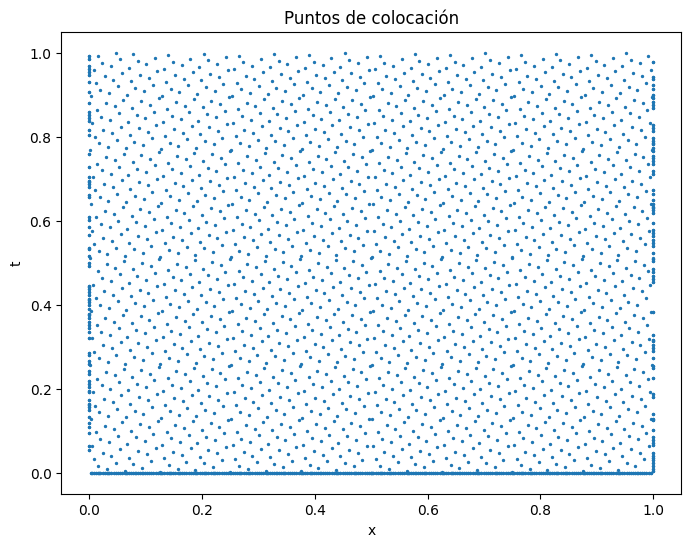

In [8]:
plots = Ploter((8,6)) # Construimos el objeto graficador para la barra
plots.collocation(data_barra, var="t") # Graficamos los puntos de colocación (train)

### **Entrenamiento**

In [9]:
#n_input=2, n_hidden=30, n_output=1, activation="tanh", mmm = "Glorot normal"

pinn_barra = PINN(n_input=2, n_hidden=100, n_output=1, activation="tanh", mmm = "Glorot normal") #Construimos la NN que resolverá la ecuación del calor aplicada a la barra
model, losshistory, train_state = pinn_barra.train_model(data_barra, steps=4000) # Entrenamiento

Compiling model...
Building feed-forward neural network...
'build' took 0.065176 s


'compile' took 0.520759 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.35e-02, 1.05e+00, 3.73e-01]    [4.51e-02, 1.05e+00, 3.73e-01]    []  
1000      [8.32e-03, 3.51e-02, 1.24e-01]    [7.09e-03, 3.51e-02, 1.24e-01]    []  
2000      [5.40e-03, 4.16e-03, 3.73e-02]    [3.32e-03, 4.16e-03, 3.73e-02]    []  
3000      [4.14e-03, 1.38e-03, 8.37e-03]    [2.76e-03, 1.38e-03, 8.37e-03]    []  
4000      [3.40e-03, 1.36e-03, 6.47e-03]    [2.25e-03, 1.36e-03, 6.47e-03]    []  

Best model at step 4000:
  train loss: 1.12e-02
  test loss: 1.01e-02
  test metric: []

'train' took 54.652999 s

Compiling model...
'compile' took 0.490671 s

Training model...

Step      Train loss                        Test loss                         Test metric
4000      [3.40e-03, 1.36e-03, 6.47e-03]    [2.25e-03, 1.36e-03, 6.47e-03]    []  

INFO:tens

## **Visualización de resultados**

Saving loss history to c:\Users\sebas\PINNs_UdeA\loss.dat ...
Saving training data to c:\Users\sebas\PINNs_UdeA\train.dat ...
Saving test data to c:\Users\sebas\PINNs_UdeA\test.dat ...


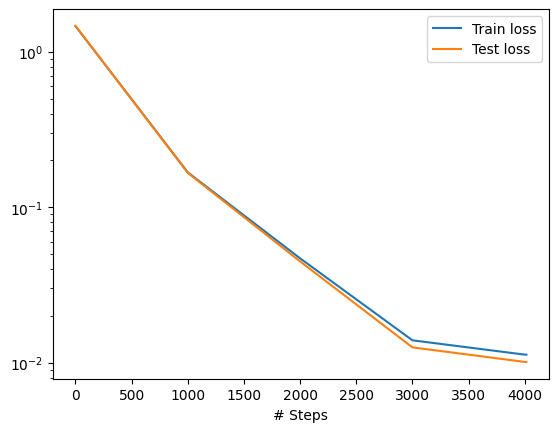

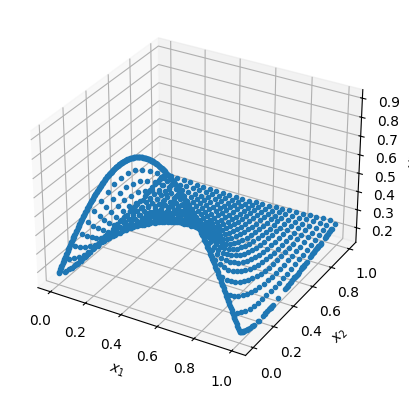

In [10]:
# Observamos la convergencia del modelo y los resultados

plots.train_plot(losshistory, train_state)

In [11]:
n=100
grid = Makegrid()
grid_terms_barra = grid.grid_2D(n, params_barra, model)

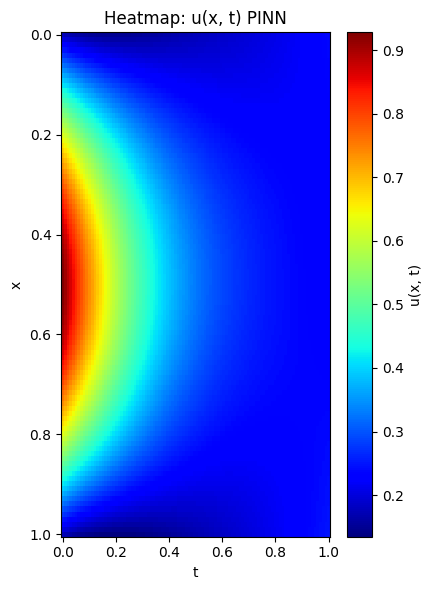

In [12]:
plots.heatmap_plot(grid_terms_barra)

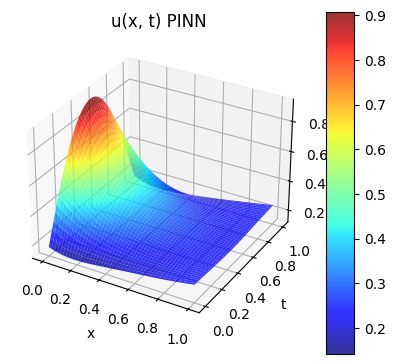

In [13]:
plots.surface_plot(grid_terms_barra)

In [ ]:
from moduleAnimation import animation_function_1d

anim = animation_function_1d(grid_terms_barra)